In [10]:
from tools import *
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20, 6


In [11]:
from sklearn import linear_model

In [12]:
ds = pd.read_csv('../yuChuli/parsedWithTest.csv',index_col=0)

In [13]:
tmp = ds[ds['store_id']==1].copy()

## 模型： 线性回归训练集构建
    # 不确定在双十节举行活动的商家，在双十一会不会举行 ： 排除节假日的数据
    # 排除十月份时期，流量异常的数据
    # 自动的从最后面的数据开始选择三个月的数据，但是最少数据没有限制，不过少于三个月数据的商家id被记录
    # 使用这三个月的数据做线性回归
    # 自变量： week（哑变量），lag-3（需要滚动的添加数据来创建测试集）， 天气（哑变量）
# 使用线性回归或者岭回归
    # 对每个商家分别建模，做7天的预测
    # 7天预测后再加入测试数据，重新建模

In [29]:
def paichuShop(pay):
	index10 = [] 

	index10_bad = []

	# pay = pd.read_csv('../../yuChuli/parsedWithTest.csv',index_col=0)
	pay.index = pd.to_datetime(pay['date'])

	for index in np.arange(1,2001,1):
		tmp = pay[pay['store_id']==index]
		tmp10 = (tmp['2016-10'])
		tmp910 = tmp['2016-09':'2016-10']

		##
		# 判断的条件为：10月的空值数，10月相对于8，9，10月的客流量中位数差异
		## (len(tmp['2016-10'])<21) or
		panduan =  \
			  \
			( tmp10['flow'].mean(axis=0) < (tmp910['flow'].mean(axis=0) -20) ) or \
			( tmp10['flow'].mean(axis=0) > (tmp910['flow'].mean(axis=0) +20) ) 


		if panduan:
			index10_bad.append(index)
			continue
		index10.append(index)

	print (index10_bad)
	# 回传适合随机森林模型的商店
	return index10

In [14]:
from rf.rfYuchuli import *

In [30]:
indexForRegression = paichuShop(ds)

[23, 31, 58, 65, 84, 88, 90, 100, 134, 140, 142, 160, 202, 233, 247, 272, 275, 286, 297, 319, 336, 368, 371, 399, 414, 428, 491, 517, 528, 555, 558, 595, 626, 627, 628, 630, 632, 637, 640, 659, 668, 687, 691, 731, 742, 749, 769, 779, 794, 803, 808, 820, 825, 829, 840, 866, 872, 891, 899, 916, 934, 1071, 1072, 1123, 1136, 1145, 1147, 1185, 1217, 1218, 1221, 1226, 1229, 1258, 1268, 1296, 1305, 1306, 1308, 1309, 1323, 1326, 1346, 1370, 1372, 1376, 1387, 1394, 1400, 1426, 1432, 1446, 1462, 1467, 1469, 1478, 1483, 1494, 1515, 1535, 1546, 1568, 1571, 1590, 1610, 1613, 1615, 1620, 1629, 1631, 1661, 1666, 1698, 1706, 1707, 1709, 1732, 1743, 1765, 1796, 1831, 1842, 1843, 1875, 1881, 1890, 1898, 1914, 1928, 1943, 1945, 1954, 1959, 1975, 1978, 1998]


In [488]:
from datetime import datetime, timedelta

for index in [indexForRegression[1]]:
#     print (index)
    tmp = ds[ds['store_id']==index]
    tmp_ = tmp.iloc[-74:-14]
    
    # 离群点标记
    q75, q25 = np.percentile(tmp_.loc[:,'flow'], [75 ,25])
    iqr = q75-q25
    
    tmp_.loc[:,'outlier'] = (tmp_.loc[:,'flow'] > (q75+iqr)).astype(int)
    
    # 自回归变量
    for cnt in range(3, len(tmp_.iloc[3:,:].index)):
        date = tmp_.iloc[3:,:].index.values[cnt]
        tmp_.at[date,'lag_1'] = tmp_['flow'][cnt - (1)]
        tmp_.at[date,'lag_2'] =  tmp_['flow'][cnt - (2)]
        tmp_.at[date,'lag_3'] =  tmp_['flow'][cnt - (3)]
    
    tmp_ = tmp_[['flow','outlier','weekday','lag_1','lag_2','lag_3']]
    # 哑变量 weekday
    tmp_ = pd.get_dummies(tmp_, columns=['weekday'])
    
    # lag 造成的空值消除
    tmp_ = tmp_.dropna()
    
    # 模型建立
#     model = linear_model.Ridge(alpha=0.01)
    model = linear_model.LassoLarsIC(criterion='aic') 
#     model = linear_model.LassoLarsCV(cv=10)
#     model.fit(tmp_.iloc[:,1:], tmp_['flow'])
    model.fit(train, ztran[0].values)

/Users/wiwi/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/wiwi/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [494]:
model.alphas_

array([  3.41873592e-02,   3.35984533e-02,   2.80897740e-02,
         2.39385628e-02,   2.22655815e-02,   1.47581187e-02,
         1.33937950e-02,   3.26553767e-03,   3.11798048e-03,
         1.89263307e-03,   1.56624536e-03,   6.59998034e-17])

In [459]:
from sklearn.preprocessing import StandardScaler 
#标准化，返回值为标准化后的数据
asdf = StandardScaler().fit_transform(tmp_[[0,2,3,4]])

In [450]:
tmp_1 = tmp_[[0,1,5,6,7,8,9,10,11]]

In [444]:
ztran = pd.DataFrame(asdf,index= tmp_1.index)
train = pd.concat([tmp_1.iloc[:,1:], ztran.iloc[:,1:]],axis=1)

### 滚动的加入样本

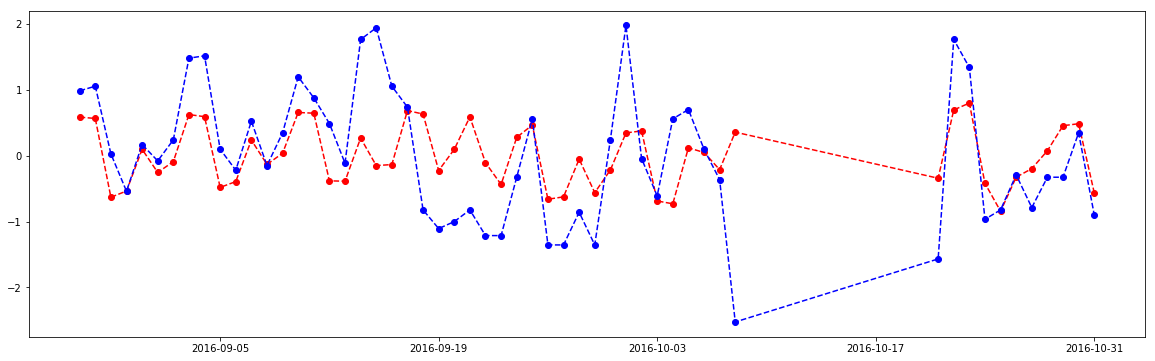

In [496]:
plt.plot(train.index, model.predict(train), 'ro--')
plt.plot(train.index, ztran[0], 'bo--')

In [490]:
model.alpha_

0.0018926330667329832

In [491]:
model.coef_

array([ 0.        , -0.10374691,  0.        ,  0.64538911,  0.        ,
        0.        ,  0.89124234,  1.08615937, -0.05088128,  0.20523996,
        0.07307783])

In [390]:
rolling = tmp_.iloc[:,:].copy()
for count11 in pd.date_range('2016-11-01','2016-11-14'):
    
    rolling.loc[pd.to_datetime(count11),:] = [\
        0,0,rolling.loc[rolling.index.values[len(rolling)-1],'flow'],\
            rolling.loc[rolling.index.values[len(rolling)-2],'flow'],\
            rolling.loc[rolling.index.values[len(rolling)-3],'flow'],0,0,0,0,0,0,0]
    
    rolling.at[pd.to_datetime(count11),'weekday_' + str((count11).isoweekday())] = 1
    
    if count11 in pd.date_range('2016-11-07','2016-11-13') and (city in bigCities):
        rolling.at[count11,'outlier'] = 1
        
    rolling.at[pd.to_datetime(count11),'flow'] = model.predict(rolling.iloc[-1:,1:])
    
    if count11 == pd.to_datetime('2016-11-07'):
        model = linear_model.LinearRegression()
        model.fit(rolling.iloc[7:,1:], rolling.iloc[7:,0])
    
    

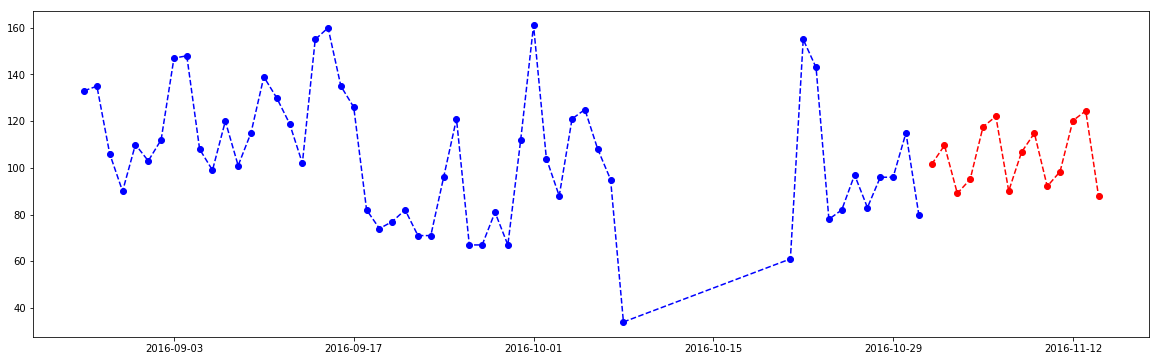

In [391]:
plt.plot(rolling.index[-14:], rolling.iloc[-14:,0], 'ro--')
plt.plot(rolling.index[:-14], rolling.iloc[:-14,0], 'bo--')